In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(1)

In [ ]:
def pad_images(images, pad_size, pad_value=0):
    '''Pad with the given value all images of inputs(a batch of image).
    The padding is applied to the height and weight of each image.

    - Args
        images: A batch of m-images of shape (m, n_h_pixels, n_w_pixels, n_channels)
        pad_size: Size of padding around each image on vertical and horizontal dimensions
        pad_value: Value to pad images; default 0

    - Returns
        Zero-padded m-images of shape (m, n_h_pixels + 2*pad, n_w_pixels + 2*pad, n_channels)
    '''
    padded_images = np.pad(images,
                           pad_width=((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0, 0)),
                           mode='constant',
                           constant_values=(pad_value, pad_value))
    return padded_images

images.shape=(4, 3, 3, 2)
padded_images.shape=(4, 9, 9, 2)


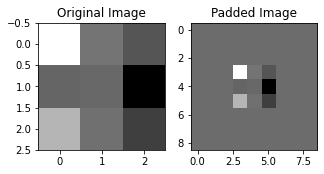

In [ ]:
np.random.seed(3)
images = np.random.randn(4, 3, 3, 2)
padded_images = pad_images(images, 3)

assert images.shape == (4, 3, 3, 2)
# assert padded_images.shape == (4, 7, 7, 1)

print(f'images.shape={images.shape}')
print(f'padded_images.shape={padded_images.shape}')

figure, axes = plt.subplots(1, 2)

image = images[0, :, :, 0]
axes[0].set_title('Original Image')
axes[0].imshow(image)

padded_image = padded_images[0, :, :, 0]
axes[1].set_title('Padded Image')
axes[1].imshow(padded_image)
plt.show()

In [ ]:
def conv_step(patch_prev, weights, bias):
    '''Perform convolution operation using a filter defined by weights on a patch
    of the output activation of the previous layer.

    - Args
        patch_prev: A patch(slice) of the input volume
                    of shape (filter_size, filter_size, n_channels_prev)
        weights: Weights contained in a window(tensor)
                 of shape (filter_size, filter_size, n_channels_prev)
        bias: Bias contained in a window of shape (1, 1, 1)

    - Returns
        z; a scalar.
        The result of convoluation operation on the given patch with weights and bias
    '''
    z = np.multiply(patch_prev, weights) # element-wise product
    z = np.sum(z) # add all elements; complete the convolution operation
    z = z + float(bias)

    return z

In [ ]:
np.random.seed(1)
patch_prev = np.random.randn(4, 4, 3)
weights = np.random.randn(4, 4, 3)
bias = np.random.randn(1, 1, 1)

z = conv_step(patch_prev, weights, bias)
print(f'z = {z}')

z = -6.999089450680221


In [ ]:
np.random.seed(1)
patch_prev = np.random.randn(4, 4, 3)
weights = np.random.randn(4, 4, 3)
bias = np.random.randn(1, 1, 1)

z = conv_step(patch_prev, weights, bias)
print(f'z = {z}')

z = -6.999089450680221


In [ ]:
def conv_forward(A_prev, weights, biases, hparams):
    '''Forward propagation for a convolution function.

    - Args
        A_prev: Output activations of the previous layer
                         of shape (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev)
        weights: Weights of shape (filter_size, filter_size, n_channels_prev, n_channels)
        bias: Biases of shape (1, 1, 1, n_channels)
        hparams: A dict containing the hyperparameters "stride", "pad_size", "pad_value"

    - Returns
        Z: The results of convolution operation of shape (m, n_h_pixels, n_w_pixels, n_channels)
        chache: Cache of values needed for the backpropagation of convolution operation
    '''
    (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev) = A_prev.shape
    (filter_size, filter_size, n_channels_prev, n_channels) = weights.shape
    
    stride = hparams['stride']
    pad_size = hparams['pad_size']
    pad_value = hparams['pad_value']

    n_h_pixels = ((n_h_pixels_prev + 2*pad_size - filter_size) // stride) + 1
    n_w_pixels = ((n_w_pixels_prev + 2*pad_size - filter_size) // stride) + 1
    
    Z = np.zeros((m, n_h_pixels, n_w_pixels, n_channels))

    padded_A_prev = np.pad(A_prev,
                            pad_width=((0, 0),
                            (pad_size, pad_size),
                            (pad_size, pad_size),
                            (0, 0)),
                            mode='constant',
                            constant_values=(pad_value, pad_value))
    
    # padded_A_prev = pad_zeros(A_prev, pad_size, pad_size, pad_value)
    
    for i in range(m):
        padded_a_prev = padded_A_prev[i]
        for h in range(n_h_pixels):
            vertical_start = h * stride
            vertical_end = vertical_start + filter_size
            for w in range(n_w_pixels):
                horizontal_start = w * stride
                horizontal_end = horizontal_start + filter_size
                for c in range(n_channels):
                    a_patch_prev = padded_a_prev[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                    weight = weights[:, :, :, c]
                    bias = biases[:, :, :, c]
                    z = np.multiply(a_patch_prev, weight)
                    z = np.sum(z) + float(bias)
                    Z[i, h, w, c] = z

    assert(Z.shape == (m, n_h_pixels, n_w_pixels, n_channels))
    cache = (A_prev, weights, biases, hparams)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10, 5, 7, 4)
weights = np.random.randn(3, 3, 4, 8)
biases = np.random.randn(1, 1, 1, 8)
hparams = {
    'pad_size': 1,
    'pad_value': 0,
    'stride': 2,
}

Z, cache = conv_forward(A_prev, weights, biases, hparams)
print(f'Z\'s mean = {np.mean(Z)}')
print(f'Z[3, 2, 1] = {Z[3, 2, 1]}')
print(f'cache[0][1][2][3] = {cache[0][1][2][3]}')

Z's mean = 0.6923608807576933
Z[3, 2, 1] = [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [ ]:
def pool_forward(A_prev, hparams, mode='max'):
    '''Forward pooling.

    - Args
        A_prev: Output activations of previous layer of shape (m, n_h_prev, n_w_prev, n_channels_prev)
        hparams: A dict containing "filter_size" and "stride"
        mode: The pooling mode to use; "max" or "average"

    - Returns
        A: Ouput of the pooling layer of shape (m, n_h_pixels, n_w_pixels, n_channels)
        cache: Cache for the backpropagation of the pooling layer contains the input and hyperparameters

    '''
    (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev) = A_prev.shape
    filter_size = hparams['filter_size']
    stride = hparams['stride']

    n_h_pixels = ((n_h_pixels_prev - filter_size) // stride) + 1
    n_w_pixels = ((n_w_pixels_prev - filter_size) // stride) + 1
    n_channels = n_channels_prev

    A = np.zeros((m, n_h_pixels, n_w_pixels, n_channels))

    for i in range(m):
        for h in range(n_h_pixels):
            vertical_start = h * stride
            vertical_end = vertical_start + filter_size
            for w in range(n_w_pixels):
                horizontal_start = w * stride
                horizontal_end = horizontal_start + filter_size
                for c in range(n_channels):
                    a_patch_prev = A_prev[i, vertical_start:vertical_end, horizontal_start:horizontal_end, c]

                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_patch_prev)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_patch_prev)

    cache = (A_prev, hparams)
    assert(A.shape == (m, n_h_pixels, n_w_pixels, n_channels))
    return A, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparams = {
    'stride': 1,
    'filter_size': 3,
}
A, cache = pool_forward(A_prev, hparams)
print('mode = max')
print(f'A.shape = {A.shape}')
print(f'A = {A}')
print()

A, cache = pool_forward(A_prev, hparams, mode='average')
print('mode = average')
print(f'A.shape = {A.shape}')
print(f'A = {A}')

mode = max
A.shape = (2, 3, 3, 3)
A = [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A = [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [ 4

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparams = {
    'stride': 2,
    'filter_size': 3,
}

A, cache = pool_forward(A_prev, hparams)
print('mode = max')
print(f'A.shape = {A.shape}')
print(f'A = {A}')
print()

A, cache = pool_forward(A_prev, hparams, mode='average')
print('mode = average')
print(f'A.shape = {A.shape}')
print(f'A = {A}')

mode = max
A.shape = (2, 2, 2, 3)
A = [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A = [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


In [ ]:
def conv_backward(dZ, cache):
    '''Backwardpropagation for a convolution function.

    - Args
        dZ: Gradient of the cost with respect to the output of the conv layer (Z)
            of shape (m, n_h_pixels, n_w_pixels, n_channels)
        cache: Cache of values for the convolution backpropagation, output of convolution forwardpropagation
    
    - Returns
        dA_prev: Gradient of the cost with respect to the input of the convolutional layer (A_prev)
                 shape of (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev)
        dW: Gradient of the cost with respect to the input of the convolutional layer (W)
            shape of (filter_size, filter_size, n_channels_prev, n_channels)
        db: Gradient of the cost with respect to the input of the convolutional layer (b)
            shape of (1, 1, 1, n_channels)
    '''
    (A_prev, W, b, hparams) = cache
    (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev) = A_prev.shape
    (filter_size, filter_size, n_channels_prev, n_channels) = W.shape
    
    stride = hparams['stride']
    pad_size = hparams['pad_size']

    (m, n_h_pixels, n_w_pixels, n_channels) = dZ.shape

    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.zeros_like(b)

    padded_A_prev = pad_images(A_prev, pad_size)
    dpadded_A_prev = pad_images(dA_prev, pad_size)

    for i in range(m):
        padded_a_prev = padded_A_prev[i]
        dpadded_a_prev = dpadded_A_prev[i]

        for h in range(n_h_pixels):
            for w in range(n_w_pixels):
                for c in range(n_channels):
                    vertical_start = h * stride
                    vertical_end = vertical_start + filter_size
                    horizontal_start = w * stride
                    horizontal_end = horizontal_start + filter_size

                    a_patch_prev = padded_a_prev[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                    dpadded_a_prev[vertical_start:vertical_end, horizontal_start:horizontal_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_patch_prev * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]

        dA_prev[i, :, :, :] = dpadded_a_prev[pad_size:-pad_size, pad_size:-pad_size, :]
    assert(dA_prev.shape == (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev))

    return dA_prev, dW, db

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparams = {'pad_size': 2,
           'pad_value': 0,
           'stride': 2}
Z, cache = conv_forward(A_prev, W, b, hparams)

dA, dW, db = conv_backward(Z, cache)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


In [ ]:
def create_mask_from_window(x):
    '''Creates a mask from input matrix x to identify the max entry of it.
    
    - Args
        x: Numpy array of shape (filter_size, filter_size)

    - Returns
        mask: Numpy array of the same shape as window, contains a True at the
              position corresponding to the max entry of matrix x
    '''
    mask = (x == np.max(x))

    return mask

In [ ]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print(f'x = {x}')
print(f'mask = {mask}')

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


In [ ]:
def distribute_contribution(dz, shape):
    '''Distribute the input value in the matrix of dimension shape
    
    - Args
        dz: input scalar
        shape: The shape of the output matrix (n_h_pixels, n_w_pixels)
               for which we want to distribute the value of dz
    - Returns
        distributed_array: Array of size (n_h_pixels, n_w_pixels) for which we distributed
                           the value of dz
    '''
    n_h_pixels, n_w_pixels = shape
    average = dz / (n_h_pixels * n_w_pixels)
    distributed_array = np.ones((n_h_pixels, n_w_pixels)) * average
    
    return distributed_array

In [ ]:
a = distribute_contribution(dz=2, shape=(2, 2))
print(f'Distributed value = {a}')

Distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [ ]:
def pool_backward(dA, cache, mode='max'):
    '''Backpropagation of the pooling layer.

    - Args
        dA: Gradient of cost with respect to the output of the pooling layer; same shape as A
        cache: Cache output from the forward propagation of the pooling layer; contains layer's input and hyperparameters
        mode: Pooling mode ("max" or "average")

    - Returns
        dA_prev: Gradient of cost with respect to the input of the pooling layer; same shape as A_prev
    '''
    A_prev, hparams = cache
    stride = hparams['stride']
    filter_size = hparams['filter_size']

    m, n_h_pixels_prev, n_w_pixels_prev, n_channels = A_prev.shape
    m, n_h_pixels, n_w_pixels, n_channels = dA.shape
    
    dA_prev = np.zeros_like(A_prev)

    for i in range(m):
        a_prev = A_prev[i]

        for h in range(n_h_pixels):
            for w in range(n_w_pixels):
                for c in range(n_channels):

                    vertical_start = h * stride
                    vertical_end = vertical_start + filter_size
                    
                    horizontal_start = w * stride
                    horizontal_end = horizontal_start + filter_size

                    if mode == 'max':
                        patch_a_prev = a_prev[vertical_start:vertical_end, horizontal_start:horizontal_end, c]
                        mask = create_mask_from_window(patch_a_prev)
                        dA_prev[i, vertical_start:vertical_end, horizontal_start:horizontal_end, c] += mask * dA[i, h, w, c]
                    
                    elif mode == 'average':
                        da = dA[i, h, w, c]
                        shape = (filter_size, filter_size)
                        dA_prev[i, vertical_start:vertical_end, horizontal_start:horizontal_end, c] += distribute_contribution(da, shape)
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparams = {"stride" : 1, "filter_size": 2}
A, cache = pool_forward(A_prev, hparams)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
